In [82]:
import pydicom as dicom
import matplotlib.pylab as plt
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import cv2
from enum import Enum
from skimage.transform import resize
from skimage.measure import label, regionprops, regionprops_table
import math
import matplotlib.patches as patches
import SimpleITK as sitk
import os
import shutil

base_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/'


"axial slices" - ? 
"axial plane" - ? I assume it means looking as a single image

Need to filter the images in the dataset.

(LEFT OUT FOR NOW - split the volume into slices for the model training (due to variance in the slice thickness?)) 

MR AND CT:

    * discard the axial slices that do not contain foreground -> if the gt of the image is empty w.r.t our classes of interest, then discard it

    * crop out the non-body region -> take the bounding box of the positive pixels, and crop the image to this bounding box
    
    * uniformly resized to 256 x 256 in axial plane

    * min-max norm to normalize to [0,1]

CT:

    * clip the value range to [-125, 275]

In [83]:
# interesting classes : 

# CLASS TO NUMBER
# (1) spleen
# (2) right kidney
# (3) left kidney
# (6) liver

class TAGS(Enum): 
    SPLEEN = 1
    RIGHT_KIDNEY = 2
    LEFT_KIDNEY = 3
    LIVER = 4


# MRI (CHAOS)
# Liver: 63 (55<<<70)
# Right kidney: 126 (110<<<135)
# Left kidney: 189 (175<<<200)
# Spleen: 252 (240<<<255) 

MRI_NUM_TO_TAG: dict = {
    252 : TAGS.SPLEEN.value,
    189: TAGS.RIGHT_KIDNEY.value,
    126 : TAGS.LEFT_KIDNEY.value,
    63: TAGS.LIVER.value
}


# CT - SYNAPSE (2015)
# (1) spleen
# (2) right kidney
# (3) left kidney
# (6) liver

CT_NUM_TO_TAG: dict = {
    1 : TAGS.SPLEEN.value,
    2 : TAGS.RIGHT_KIDNEY.value,
    3 : TAGS.LEFT_KIDNEY.value,
    6 : TAGS.LIVER.value
}


In [84]:

def setup_img_fig(img1 : np.ndarray, img2: np.ndarray):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))  # Adjust figsize for image sizes

    axes[0].imshow(img1)
    axes[0].set_title("Image 1")
    axes[0].axis('off')  # Hide axes for cleaner presentation

    axes[1].imshow(img2)
    axes[1].set_title("Image 2")
    axes[1].axis('off')
    
    return fig,axes

def get_bbox(array: np.ndarray):
    array_for_bbox =  (array > 0).astype(np.uint8)
    
    bbox = regionprops(array_for_bbox)[0].bbox
    
    return bbox

def get_bbox_for_batch(array: np.ndarray):
    bbox_list = []
    num_in_batch = array.shape[2]
    for i in range(num_in_batch):
        sub_array = array[:,:,i]
        bbox = get_bbox(sub_array)
        bbox_list.append(bbox)
    return np.stack(bbox_list)

def show_bbox_on_image(ax, bbox):
    y_size = bbox[2] - bbox[0]
    x_size = bbox[3] - bbox[1]
    rect = patches.Rectangle((bbox[1], bbox[0]), x_size, y_size, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    

def get_bbox_from_mask(mask, outside_value=0):
    mask_voxel_coords = np.where(mask != outside_value)
    minzidx = int(np.min(mask_voxel_coords[0]))
    maxzidx = int(np.max(mask_voxel_coords[0])) + 1
    minxidx = int(np.min(mask_voxel_coords[1]))
    maxxidx = int(np.max(mask_voxel_coords[1])) + 1
    minyidx = int(np.min(mask_voxel_coords[2]))
    maxyidx = int(np.max(mask_voxel_coords[2])) + 1
    return [[minzidx, maxzidx], [minxidx, maxxidx], [minyidx, maxyidx]]

Start with MRI


In [85]:
# img_path = "/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/chaos/train/Train_Sets/MR/8/T2SPIR/DICOM_anon/"
# label_path = "/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/chaos/train/Train_Sets/MR/8/T2SPIR/Ground"
# reader = sitk.ImageSeriesReader()
# dicom_names = reader.GetGDCMSeriesFileNames(img_path)
# reader.SetFileNames(dicom_names)
# img = reader.Execute()
# img = sitk.GetArrayFromImage(img)

# print("ddd")

TypeError: exceptions must derive from BaseException

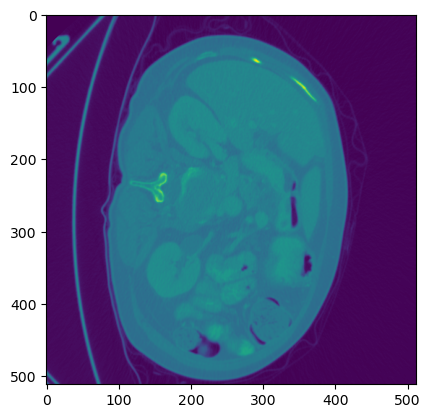

In [86]:
def add_mask(img,mask):  
    label2color = {0:np.array([0,0,0]),1:np.array([251,111,111]),2:np.array([240,130,40]),3:np.array([206,242,151]),4:np.array([238,172,255]),5:np.array([0,255,255])}
    
    pred_mask = np.zeros_like(img).astype(np.uint8)
    for l,color in label2color.items():
        pred_mask[mask==l, : ] = color
    img_pred = cv2.addWeighted(img,0.5,pred_mask,0.5,0,0)
    return img_pred

# specify your image path
mr_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0001.nii.gz'
mr_im = nib.load(mr_path)
mr_im_data = mr_im.get_fdata()

gt_mr_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/label/label0001.nii.gz'

gt_mr = nib.load(gt_mr_path)
gt_mr_data = gt_mr.get_fdata()

loaded_np = np.load('/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT/train/img0008_53.npz')
mr_im_data = loaded_np["image"]
gt_mr_data = loaded_np["label"]

loaded_np_mr = np.load('/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/MR/train/IMG:VOL1-0002_34.npz')
mr_im_data_mr = loaded_np_mr["image"]
gt_mr_data_mr = loaded_np_mr["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 6))  # Adjust figsize for image sizes

axes[0].imshow((mr_im_data *255).astype(np.uint8))
axes[0].set_title("Image 1")
axes[0].axis('off')  # Hide axes for cleaner presentation

axes[1].imshow((mr_im_data_mr * 255).astype(np.uint8))
axes[1].set_title("Image 2")
axes[1].axis('off')

# plt.imshow(gt_mr_data)

# plt.imshow(gt_mr)

plt.show()
# mr_im_data = (mr_im_data * 255)
# im = add_mask(np.stack([mr_im_data[:,:,1],mr_im_data[:,:,1],mr_im_data[:,:,1]],axis=2).astype(np.uint8), gt_mr_data)
# plt.imshow(im)


constants

In [ ]:
training_size : tuple = (256,256)

In [ ]:
prod_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT'

mr_path_train = prod_path +  '/train'
mr_path_test = prod_path +  '/test'
if os.path.exists(mr_path_train):
    shutil.rmtree(mr_path_train, ignore_errors=True)
if os.path.exists(mr_path_test):
    shutil.rmtree(mr_path_test, ignore_errors=True)

os.makedirs(mr_path_train,exist_ok=True)
os.makedirs(mr_path_test,exist_ok=True)

In [ ]:
import random 
import os 
import re

files = [ f.path.split('/')[-1] for f in os.scandir(base_path) ]
files = [int(f.split('.')[0].split('mg')[1]) for f in files]
random.shuffle(files)
train_size = int(len(files) * 0.8)

train_vols = set(files[:train_size])
test_vols = set(files[train_size:])

print(f"train vols: {train_vols}")
print(f"test vols: {test_vols}")

def is_train_vol(vol: str):
    return vol in train_vols

def get_data_save_path(im_path: str):
    im_name = im_path.split('/')[-1].split('.')[0]
    splitted_name = im_name.split('-')
    im_name_new = f'{splitted_name[0]}-{splitted_name[1]}_{int(splitted_name[2])}'
    im_name = f'/{im_name_new}'
    
    if is_train_vol(vol):
        return mr_path_train + im_name, vol
    else:
        return mr_path_test + im_name, vol

def get_data_save_path_ct(im_path: str, slice_idx:int):
    im_name = im_path.split('/')[-1].split('.')[0]
    vol = int(im_name.split('mg')[1])
    print(im_name)
    
    im_name_new = f'{im_name}_{slice_idx}'
    im_name = f'/{im_name_new}'
        
    if is_train_vol(vol):
        return mr_path_train + im_name, vol
    else:
        return mr_path_test + im_name, vol

train vols: {1, 2, 3, 6, 7, 8, 9, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 40}
test vols: {4, 5, 39, 10, 22, 30}


In [ ]:
import os
import re
import random 
# /users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/chaos/train/Train_Sets/MR/8/T2SPIR/DICOM_anon/

base_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img'

im_path_list = []
gt_path_list = []

root_dirs = set()

for root,a,files in os.walk(base_path):
    for file in files:
        full_path = os.path.join(root, file)
        full_path_gt = os.path.join(root.replace('/img', '/label'), file.replace('img','label'))
        im_path_list.append(full_path)
        gt_path_list.append(full_path_gt)
        root_dirs.add(root)

print(im_path_list)
print(gt_path_list)
print(root_dirs)

['/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0001.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0031.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0026.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0005.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0023.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0022.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0004.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0028.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/A

In [ ]:
# # im_path_list = [mr_path]
# # gt_path_list = [gt_mr_path]
# from dataclasses import dataclass

# def add_mask(img,mask):  
#     label2color = {0:np.array([0,0,0]),1:np.array([251,111,111]),2:np.array([240,130,40]),3:np.array([206,242,151]),4:np.array([238,172,255]),5:np.array([0,255,255])}
    
#     pred_mask = np.zeros_like(img).astype(np.uint8)
#     for l,color in label2color.items():
#         pred_mask[mask==l, : ] = color
#     img_pred = cv2.addWeighted(img,0.1,pred_mask,0.9,0,0)
#     return img_pred

# @dataclass
# class VolData:
#     data_path: str
#     image:  np.ndarray
#     label: np.ndarray
    

# vol_to_arr : dict[str,list[VolData]] = {}

# for im_path,gt_path in zip(im_path_list,gt_path_list):
    
#     mr_im = nib.load(im_path)
        
#     gt_mr = nib.load(gt_path).get_fdata()

#     # 0 to 1552
#     mr_im_data = mr_im.get_fdata()
    
#     filtered_gt = np.zeros_like(gt_mr)
#     # swap to our tags
#     for item in CT_NUM_TO_TAG.items():
#         filtered_gt = np.where(gt_mr == item[0], item[1], filtered_gt) 
    
#     gt_mr = filtered_gt[:,:,~np.all(filtered_gt==0, axis=(0,1))]
#     mr_im_data = mr_im_data[:,:,~np.all(filtered_gt==0, axis=(0,1))]
    
#     print(gt_mr[:,:,1].shape)
#     print(mr_im_data[:,:,1][...,np.newaxis].shape)
#     vis = add_mask(np.stack([mr_im_data[:,:,1],mr_im_data[:,:,1],mr_im_data[:,:,1]],axis=2).astype(np.uint8), gt_mr[:,:,1])
#     # plt.imshow(gt_mr[:,:,1])
#     plt.imshow(vis)
#     break

TypeError: exceptions must derive from BaseException

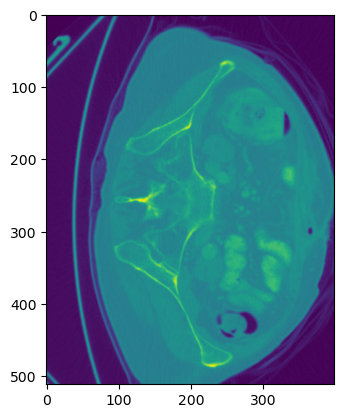

In [ ]:
# im_path_list = [mr_path]
# gt_path_list = [gt_mr_path]
from dataclasses import dataclass

@dataclass
class VolData:
    data_path: str
    image:  np.ndarray
    label: np.ndarray
    

vol_to_arr : dict[str,list[VolData]] = {}

for im_path,gt_path in zip(im_path_list,gt_path_list):
    
    mr_im = nib.load(im_path)
        
    gt_mr = nib.load(gt_path).get_fdata()

    # 0 to 1552
    mr_im_data = mr_im.get_fdata()
    
    filtered_gt = np.zeros_like(gt_mr)
    # swap to our tags
    for item in CT_NUM_TO_TAG.items():
        filtered_gt = np.where(gt_mr == item[0], item[1], filtered_gt) 
    
    gt_mr = filtered_gt[:,:,~np.all(filtered_gt==0, axis=(0,1))]
    mr_im_data = mr_im_data[:,:,~np.all(filtered_gt==0, axis=(0,1))]
    
    # filter out empty images, "no foreground"
    if gt_mr.shape[2] == 0:
        continue
    
    # crop out the body region with this bbox
    # **bbox** : tuple
    # Bounding box ``(min_row, min_col, max_row, max_col)``.
    # Pixels belonging to the bounding box are in the half-open interval
    # ``[min_row; max_row)`` and ``[min_col; max_col)``.
    bbox_np = get_bbox_for_batch(mr_im_data > 0)
    
    im_list = []
    gt_list = []
    for slc in range(bbox_np.shape[0]):
        bbox = bbox_np[slc]
        im_cropped = mr_im_data[bbox[0]:bbox[2], bbox[1]:bbox[3], slc]
        gt_cropped = gt_mr[bbox[0]:bbox[2], bbox[1]:bbox[3], slc]
    
        
        # NOTE - order 0 is `nearest neighbor` interpolation. We need it for the segmentation mask
        # NOTE - The image should be resized with some sort of interpolation,
        resized_gt = resize(gt_cropped, training_size, order=0, mode="edge", clip=True, anti_aliasing=False).astype(np.uint8)
        resized_im = resize(im_cropped.astype(float), training_size, order=3, mode="edge", clip=True, anti_aliasing=False)
        
        # minmax norm + clip
        clipped_im = np.clip(resized_im, -125, 275)    
        normed_im = (clipped_im - clipped_im.min()) / (clipped_im.max() - clipped_im.min())
        
        im_list.append(normed_im)
        gt_list.append(resized_gt)
    stacked_ims = np.stack(im_list)
    stacked_gts = np.stack(gt_list)
    # im_cropped  = mr_im_data[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    # gt_cropped =  gt_mr[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    

    
    # print(im_cropped.shape)
    # print(im_cropped.dtype)
    # print(gt_cropped.dtype)
    # print(resized_im.max())
    
    
    for idx in range(stacked_ims.shape[0]):
        data_path, vol = get_data_save_path_ct(im_path, idx)
        if vol not in vol_to_arr:
            vol_to_arr[vol] = []
        im = stacked_ims[idx]
        gt = stacked_gts[idx]
        gt_newdim = gt[np.newaxis, ...]
        vol_to_arr[vol].append(VolData(data_path, im, gt_newdim))
    
for vol, vol_data_list in vol_to_arr.items():
    for idx,vol_data in enumerate(vol_data_list):
        mixed_image = None
        if idx == 0:
            next_slice = vol_data_list[idx+1]
            mixed_image = np.stack([vol_data.image,vol_data.image, next_slice.image])
        elif idx == len(vol_data_list) - 1:
            prev_slice = vol_data_list[idx - 1]
            mixed_image = np.stack([prev_slice.image, vol_data.image,vol_data.image])
        else:
            prev_slice = vol_data_list[idx - 1]
            next_slice = vol_data_list[idx+1]
            print(f"getting slices {prev_slice}, {idx}, {next_slice}")
            mixed_image = np.stack([prev_slice.image, vol_data.image,next_slice.image])
            
        img = np.flip(mixed_image.transpose((1,2,0)),axis=0)
        label = np.flip(vol_data.label.transpose((1,2,0)),axis=0)[:,:,0]
        print(f"saving data to {vol_data.data_path}")
        np.savez(vol_data.data_path, image = img, label = label)
    

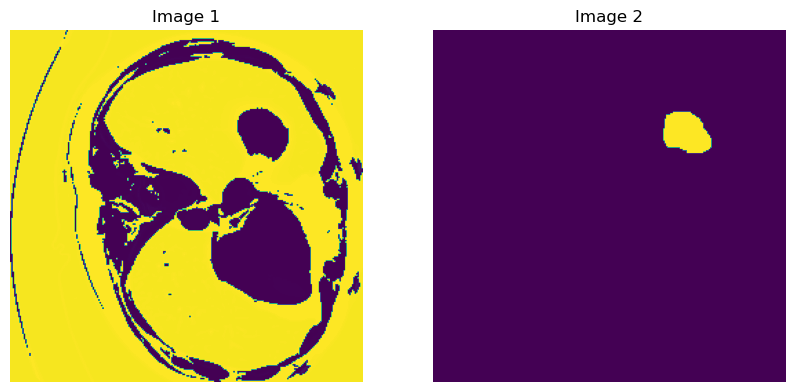

In [ ]:
fig, axes = setup_img_fig(resized_im,resized_gt)

plt.show()

In [ ]:
# test that the data was created successfully
import numpy as np 

test_im_gt_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT/train/img0001_0.npz'
test_im_same_vol_gt_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT/train/img0001_1.npz'
test_im_diff_vol_gt_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT/train/img0006_55.npz'

def get_image_labels_from_npz(npz_path: str):
    test_im_npz = np.load(npz_path)    
    return test_im_npz["image"], test_im_npz["label"]

test_im, test_gt = get_image_labels_from_npz(test_im_gt_path)
test_im_same_vol, test_gt_same_vol = get_image_labels_from_npz(test_im_same_vol_gt_path)
test_im_diff_vol, test_gt_diff_vol = get_image_labels_from_npz(test_im_diff_vol_gt_path)

assert test_gt.max() > 0
assert test_gt_same_vol.max() > 0
assert test_gt_diff_vol.max() > 0

assert np.all(test_im[:,:,2] == test_im_same_vol[:,:,1])
assert np.all(test_im[:,:,0] == test_im[:,:,1])
assert np.any(test_im[:,:,0] != test_im[:,:,2])

assert np.any(test_im_same_vol[:,:,2] != test_im_same_vol[:,:,1])
assert np.any(test_im_same_vol[:,:,0] != test_im_same_vol[:,:,2])
assert np.any(test_im_same_vol[:,:,0] != test_im_same_vol[:,:,1])

assert np.any(test_im[:,:,2] != test_im_diff_vol[:,:,1])
assert np.any(test_im[:,:,2] != test_im_diff_vol[:,:,2])
assert np.any(test_im[:,:,2] != test_im_diff_vol[:,:,0])

assert np.any(test_gt[:,:] != test_gt_diff_vol[:,:])
assert np.any(test_gt[:,:] != test_gt_diff_vol[:,:])
assert np.any(test_gt[:,:] != test_gt_diff_vol[:,:])

assert np.any(test_gt[:,:] != test_gt_same_vol[:,:])
